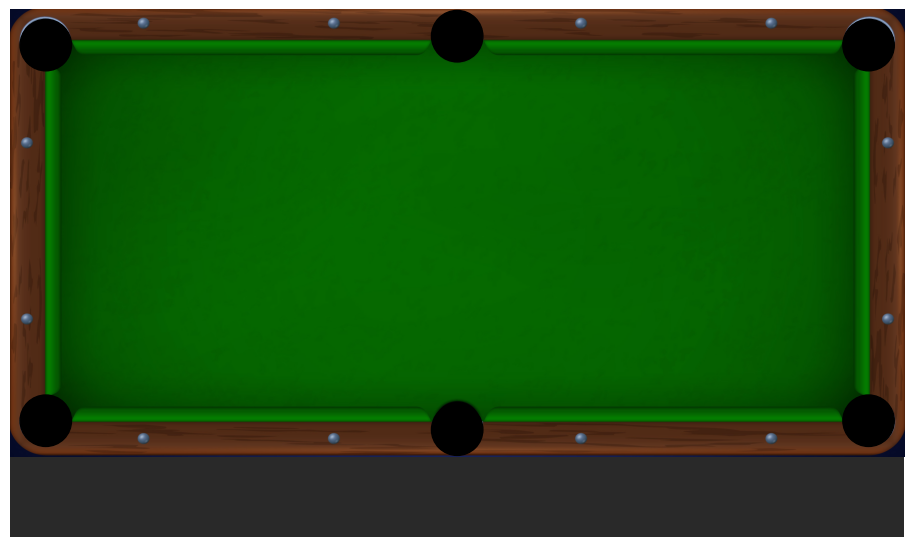

In [ ]:
import math
import random
import os
import tkinter as tk
from tkinter import ttk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# =========================
# CONFIG
# =========================
TABLE_W, TABLE_H = 200, 100
INFO_PANEL_H = 18
BALL_R = 2.5
MAX_CUT_ANGLE = 65

TABLE_IMAGE = "pool_table.jpeg"
if not os.path.exists(TABLE_IMAGE):
    raise FileNotFoundError("pool_table.jpeg not found")

POCKETS = {
    "TL": (8, 8), "TM": (100, 6), "TR": (192, 8),
    "BL": (8, 92), "BM": (100, 94), "BR": (192, 92)
}

SCENARIO = {"EASY":1,"NORMAL":2,"HARD":3,"CUSTOM":4}

SCENARIO_TEXT = {
    1:"EASY: Click WHITE → Click COLORED",
    2:"NORMAL: Click a colored ball",
    3:"HARD: More blocking",
    4:"CUSTOM: Place balls, double-click colored"
}

# =========================
# GEOMETRY
# =========================
def dist(a,b): return math.hypot(a[0]-b[0], a[1]-b[1])

def angle_between(v1,v2):
    dot = v1[0]*v2[0]+v1[1]*v2[1]
    m1,m2 = math.hypot(*v1), math.hypot(*v2)
    if m1==0 or m2==0: return 180
    return math.degrees(math.acos(max(-1,min(1,dot/(m1*m2)))))

def segment_hits_ball(a,b,c):
    lab = dist(a,b)
    if lab==0: return False
    t = max(0,min(1,((c[0]-a[0])*(b[0]-a[0])+(c[1]-a[1])*(b[1]-a[1]))/lab**2))
    p = (a[0]+t*(b[0]-a[0]), a[1]+t*(b[1]-a[1]))
    return dist(p,c) < BALL_R*2

# =========================
# SHOT LOGIC
# =========================
def compute_shots(white,target,blockers):
    shots=[]
    for pname,pocket in POCKETS.items():
        vx,vy = pocket[0]-target[0], pocket[1]-target[1]
        d = math.hypot(vx,vy)
        if d==0: continue

        ghost = (target[0]-vx/d*BALL_R*2, target[1]-vy/d*BALL_R*2)

        cut = angle_between((ghost[0]-white[0],ghost[1]-white[1]),
                            (pocket[0]-target[0],pocket[1]-target[1]))

        if cut>MAX_CUT_ANGLE: continue
        if any(segment_hits_ball(white,ghost,b) or segment_hits_ball(target,pocket,b)
               for b in blockers): continue

        power = min(100, int(dist(white,ghost)*1.1))
        conf = max(0,100-int(cut*1.4))

        shots.append({
            "pocket":pname,
            "cut":cut,
            "power":power,
            "conf":conf,
            "path":[white,ghost,pocket]
        })

    return sorted(shots,key=lambda s:(s["cut"],-s["conf"]))[:2]

# =========================
# STATE
# =========================
white=None
colored=[]
selected=None
clicks=[]
current_scenario=None

# =========================
# TKINTER
# =========================
root=tk.Tk()
root.title("Pool AI Trainer")
root.geometry("1250x700")

fig,ax=plt.subplots(figsize=(9.5,5))
img=plt.imread(TABLE_IMAGE)

canvas=FigureCanvasTkAgg(fig,root)
canvas.get_tk_widget().pack(side=tk.LEFT,fill=tk.BOTH,expand=True)

# =========================
# DRAW HELPERS
# =========================
def draw_ball(p,c):
    ax.add_patch(plt.Circle(p,BALL_R,fc=c,ec="black",zorder=5))
    ax.add_patch(plt.Circle((p[0]-0.6,p[1]-0.6),BALL_R*0.35,
                            fc="white",alpha=0.35,zorder=6))

# =========================
# DRAW
# =========================
def redraw():
    ax.clear()
    ax.set_xlim(0,TABLE_W)
    ax.set_ylim(TABLE_H+INFO_PANEL_H,0)
    ax.axis("off")
    ax.imshow(img,extent=[0,TABLE_W,TABLE_H,0],zorder=0)

    for p in POCKETS.values():
        ax.add_patch(plt.Circle(p,BALL_R*2.3,color="black",zorder=3))

    if white: draw_ball(white,"white")
    for b in colored: draw_ball(b,"#1f77b4")
    if selected: draw_ball(selected,"red")

    shots=[]
    if white and selected:
        shots=compute_shots(white,selected,[b for b in colored if b!=selected])
        colors=["#ff3333","#ffaa00"]
        for i,s in enumerate(shots):
            xs=[p[0] for p in s["path"]]
            ys=[p[1] for p in s["path"]]
            ax.plot(xs,ys,color=colors[i],lw=4,zorder=4)

    ax.add_patch(plt.Rectangle((0,TABLE_H),TABLE_W,INFO_PANEL_H,
                               fc="#111111",alpha=0.9,zorder=10))

    for i,s in enumerate(shots):
        txt=(f"BEST {i+1} → {s['pocket']} | "
             f"Angle: {s['cut']:.1f}° | "
             f"Power: {s['power']}% | "
             f"Confidence: {s['conf']}%")
        ax.text(5,TABLE_H+6+i*7,txt,color="white",fontsize=10,zorder=11)

    if current_scenario:
        ax.text(5,95,SCENARIO_TEXT[current_scenario],
                bbox=dict(facecolor="white",alpha=0.9))

    canvas.draw()

# =========================
# CLICK HANDLER
# =========================
def on_click(e):
    global white,selected
    if e.inaxes!=ax or not current_scenario: return
    pos=(e.xdata,e.ydata)

    if current_scenario == 1:  # EASY
        if not white:
            white = pos
        else:
            for b in colored:
                if dist(pos,b)<BALL_R*2:
                    selected=b

    elif current_scenario==4:
        if not white: white=pos
        elif len(colored)<4: colored.append(pos)
        else:
            for b in colored:
                if dist(pos,b)<BALL_R*2:
                    clicks.append(b)
                    if clicks.count(b)==2: selected=b
    else:
        for b in colored:
            if dist(pos,b)<BALL_R*2: selected=b

    redraw()

canvas.mpl_connect("button_press_event",on_click)

# =========================
# SCENARIOS
# =========================
def setup(s):
    global white,colored,selected,clicks,current_scenario
    white=None; colored=[]; selected=None; clicks=[]
    current_scenario=s

    if s == 1:  # EASY
        for _ in range(3):
            colored.append((random.uniform(40,160),random.uniform(25,75)))

    if s in (2,3):
        white=(random.uniform(40,160),random.uniform(25,75))
        for _ in range(3 if s==2 else 4):
            colored.append((random.uniform(40,160),random.uniform(25,75)))

    redraw()

panel=tk.Frame(root,padx=10)
panel.pack(side=tk.RIGHT,fill=tk.Y)

for name,val in SCENARIO.items():
    ttk.Button(panel,text=name,
               command=lambda v=val:setup(v)).pack(fill="x",pady=5)

redraw()
root.mainloop()
